In [1]:
import sys
sys.path.append("/home/wanxinli/EHR-OT/")

import matplotlib.pyplot as plt
from math import floor, ceil
from mimic_common import *
import os
import pandas as pd

/home/wanxinli/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def read_df(group_name, group_1, group_2, suffix = None, ratio_bound = 20):
    """ 
    Absoluate bound for filtering out ratios
    """

    source_equity_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{group_2}2{group_1}_source_equity.csv")
    if suffix is not None:
        source_equity_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{group_2}2{group_1}_{suffix}_source_equity.csv")
    source_equity_df = pd.read_csv(source_equity_path, header=0, index_col=None)

    target_equity_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{group_2}2{group_1}_target_equity.csv")
    if suffix is not None:
        target_equity_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{group_2}2{group_1}_{suffix}_target_equity.csv")
    target_equity_df = pd.read_csv(target_equity_path, header=0, index_col=None)

    target_diff_percents = target_equity_df['target_diff_percent']
    target_diff_percents = [x for x in target_diff_percents if abs(x) < ratio_bound]
    source_diff_percents = source_equity_df['source_diff_percent']
    source_diff_percents = [x for x in source_diff_percents if abs(x) < ratio_bound]

    return source_diff_percents, target_diff_percents

In [3]:
def plot_percents(group_name, group_1, group_2, source_diff_percents, target_diff_percents, ratio_bound = 20):
    bin_width = 0.1

    plt.hist(source_diff_percents, bins=np.arange(-ratio_bound, \
                ratio_bound + bin_width, bin_width), density=True, alpha=0.5, label='source')
    plt.hist(target_diff_percents, bins=np.arange(-ratio_bound, \
                ratio_bound + bin_width, bin_width), density=True, alpha=0.5, label='transported target')
    plt.ylabel("density")
    plt.xlabel("difference in MAE ratio")
    plt.legend()
    save_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{group_2}2{group_1}_fairness.pdf")
    plt.savefig(save_path)
    plt.show()

In [4]:
def procedure_bias(source_diff_percents, target_diff_percents):
    """ 
    Quantifies the procedural bias between source error and target error
    :param list[float] source_diff_percents: (predicted value - ground truth value)/(ground truth value) for source 
    :param list[float] target_diff_percents: (transported predicted value - ground truth value)/(ground truth value) for target
    """
    
    source_bias = ([True for i in source_diff_percents if i > 0].count(True))/len(source_diff_percents) # also as model bias
    target_bias = ([True for i in target_diff_percents if i > 0].count(True))/len(target_diff_percents)
    print(f"source bias is {source_bias}, target bias is {target_bias}")
    return target_bias - source_bias

In [5]:
def entire_proc(group_name, group_1, group_2, ratio_bound = 20):
    source_diff_percents, target_diff_percents = read_df(group_name, group_1, group_2, ratio_bound = ratio_bound)
    plot_percents(group_name, group_1, group_2, source_diff_percents, target_diff_percents)
    return procedure_bias(source_diff_percents, target_diff_percents)

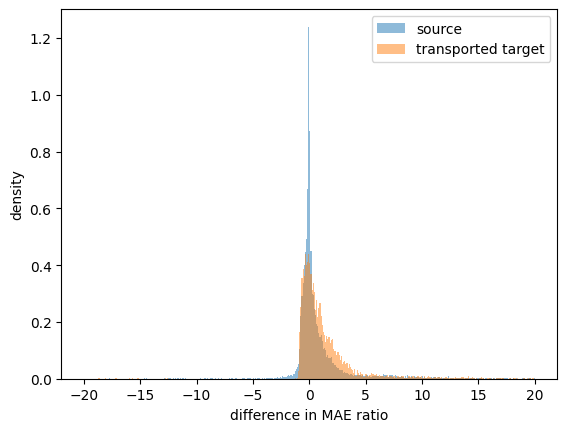

source bias is 0.538560411311054, target bias is 0.6747752511898466


0.13621483987879257

In [6]:
group_name = 'insurance'
group_1 = 'Medicaid'
group_2 = 'Self_Pay'

entire_proc(group_name, group_1, group_2)

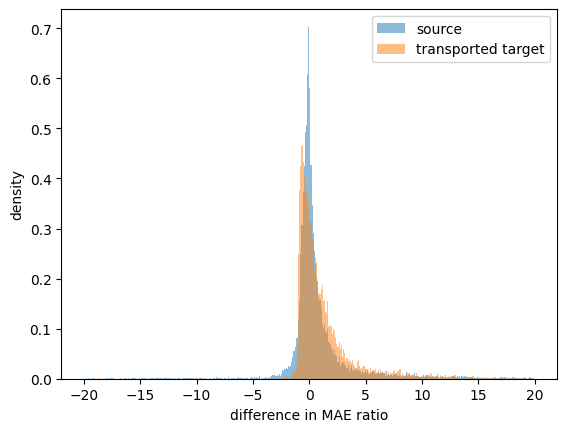

source bias is 0.5315315315315315, target bias is 0.6028851388132825


0.071353607281751

In [7]:
group_name = 'insurance'
group_1 = 'Self_Pay'
group_2 = 'Medicaid'

entire_proc(group_name, group_1, group_2)